In [1]:
import pandas as pd
import numpy as np
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import beta



import upsetplot as up
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()


prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

In [ ]:
subsample_output_folder = f'{prefix}/config/subsampling'

In [3]:
# load in the configs for each 
subsample_nums = [100, 200, 250, 300, 350, 400, 450]

sub_configs = {}
for num_samples in subsample_nums:
    config_path= f'{subsample_output_folder}/{num_samples}_subsample.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        sub_configs[num_samples] = config

main_config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(main_config_path, 'r') as f:
    final_output_config = yaml.safe_load(f)


tissue_ids = load_tissue_ids(final_output_config)
tissue_df = load_tissue_df(final_output_config)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


my_tissue_id = 'Cells_Cultured_fibroblasts'
sample_sizes = pd.read_csv(final_output_config['gtex_meta'], sep='\t')
final_sample_size = sample_sizes[sample_sizes['tissue_id']==my_tissue_id]['sample_size'].values[0]


In [4]:
# takes 13 minutes for 1 tissues and 4 subsamples

sig_threshold = 10e-6

def get_pc_e_nominal(config, tissue_id):
    pc_nominal_df = load_pc_nominal_all_chr(config, tissue_id).groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})
    e_nominal_df = load_e_nominal_all_chr(config, tissue_id).groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})
    #pc_nominal_df = load_pc_nominal(config, tissue_id).groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})
    #e_nominal_df = load_e_nominal(config, tissue_id).groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})
    pc_nominal_df['sig'] = pc_nominal_df['pval_nominal'] < sig_threshold
    e_nominal_df['sig'] = e_nominal_df['pval_nominal'] < sig_threshold
    combined_nominal = pd.merge(pc_nominal_df, e_nominal_df, suffixes=['_pc', '_e'], on=['cluster_id', 'variant_id']).reset_index()
    combined_nominal['exclusive_label'] = np.where(combined_nominal['sig_e'],
                                               np.where(combined_nominal['sig_pc'], 'shared', 'eqtl_only'), 
                                               np.where(combined_nominal['sig_pc'], 'pcqtl_only', 'neither'))
    return combined_nominal
nominal_df = get_pc_e_nominal(final_output_config, my_tissue_id)
for key in sub_configs:
    print(key)
    sub_nominal_df = final_nominal_df = get_pc_e_nominal(sub_configs[key], my_tissue_id)
    nominal_df = pd.merge(nominal_df, sub_nominal_df, suffixes=['', f'_{key}'], on=['cluster_id', 'variant_id'])


100
200
250
300
350
400
450


<AxesSubplot: xlabel='sample_size', ylabel='pval_e'>

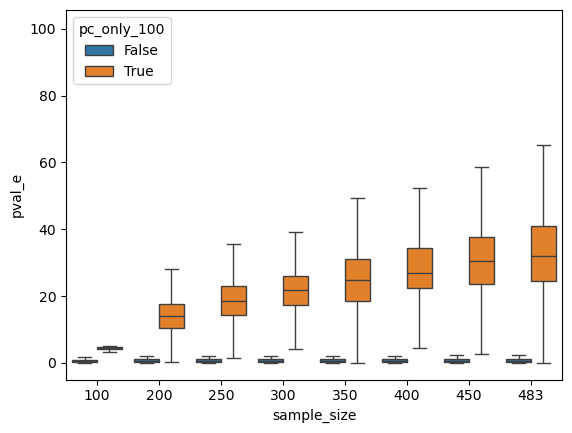

In [5]:
# look at ones that are signifigant pc at 100 samples
nominal_df['pc_only_100'] = nominal_df['sig_pc_100']&~nominal_df['sig_e_100']
downsampled_nominal = pd.concat([nominal_df[nominal_df['pc_only_100']], nominal_df[~nominal_df['pc_only_100']].sample(10000)])

downsampled_nominal = downsampled_nominal.rename(columns={'pval_nominal_e':f'pval_nominal_e_{final_sample_size}'})
col_names = [f'pval_nominal_e_{num}' for num in subsample_nums]
col_names.append(f'pval_nominal_e_{final_sample_size}')
melt_nominal_df = downsampled_nominal.melt(id_vars=['variant_id', 'cluster_id', 'pc_only_100'], var_name='sample_size', value_name='pval_e', value_vars=col_names)
melt_nominal_df['sample_size'] = melt_nominal_df['sample_size'].str.split('_e_').str[1].astype(int)

melt_nominal_df['pval_e'] =-np.log10(melt_nominal_df['pval_e'])
sns.boxplot(melt_nominal_df, x='sample_size', y='pval_e', hue='pc_only_100', fliersize=0)


In [89]:
# look at ones that are pc_only at 200 samples
nominal_200_pc = nominal_df[nominal_df['exclusive_label_200']=='pcqtl_only']

In [90]:
# bar plot with fraction in each category
pc_only_sig = nominal_200_pc.rename(columns={'exclusive_label':f'exclusive_label_{final_sample_size}'})
col_names = [f'exclusive_label_{num}' for num in subsample_nums[1:]]
col_names.append(f'exclusive_label_{final_sample_size}')

# make the data to plot
melt_pc_sig = pc_only_sig.melt(id_vars=['variant_id', 'cluster_id'], var_name='sample_size', value_name='exclusive_label', value_vars=col_names)
melt_pc_sig['sample_size'] = melt_pc_sig['sample_size'].str.split('label_').str[1].astype(int)
count_data = melt_pc_sig.groupby(['sample_size', 'exclusive_label']).size().reset_index(name='counts')
# make a fraciton
count_data['fraction'] = count_data['counts']/count_data[(count_data['sample_size']==200)& (count_data['exclusive_label']=='pcqtl_only')]['counts'].iloc[0]

count_data['label_to_plot'] = count_data['exclusive_label'].map({'shared':'Both', 
                                   'pcqtl_only':'pcQTL only',
                                   'eqtl_only':'eQTL only',
                                   'neither':'Neither'})

fig = px.bar(count_data, x='sample_size', y='fraction', color='label_to_plot', 
             color_discrete_sequence=["#B83A4B", "#67AFD2", "grey", "#734675"])

# Set background color to white
fig.update_layout(
    template='simple_white'
)

# Update axes labels
fig.update_layout(
    yaxis_title='Fraction variants',
    xaxis_title='Number RNA-seq samples',
    legend_title_text='Nominal p-value < 10e-6?',
    title='Signifigance of 200-sample-pcQTL variants across increasing subsamples'
)

fig.show()

In [92]:
nominal_200_pc = nominal_df[nominal_df['exclusive_label_200']=='pcqtl_only']

# Create dimensions
dimensions = []
for sample_size in [200,250,300, 350, 400, 450]:
    dimensions.append(go.parcats.Dimension(
        values=nominal_200_pc[f'exclusive_label_{sample_size}'],
        categoryorder='category descending', label=f"{sample_size} sample"))

dimensions.append(go.parcats.Dimension(
    values=nominal_200_pc.exclusive_label,
    categoryorder='category ascending', label="{} sample".format(final_sample_size)))

# colors based on orig group
color_map = {'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675', 'neither':'grey'}
color = [color_map[label] for label in nominal_200_pc.exclusive_label]


fig = go.Figure(data = [go.Parcats(dimensions=dimensions,
        line={'color': color},
        hoveron='color', hoverinfo='count+probability',
        arrangement='freeform')])

fig.show()
